In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import time
import keras
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from bs4 import BeautifulSoup


from sklearn.neighbors import NearestNeighbors
from scipy import sparse as sp

from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dot, Embedding, Flatten, Dense
from sklearn.cluster import KMeans

In [2]:
# download the data from https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews/

In [3]:
#importing the training data
imdb_data=pd.read_csv('/home/koki/Desktop/Data/NLP/IMDB Dataset.csv')
print(imdb_data.shape)

(50000, 2)


In [4]:
imdb_data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
reviews = imdb_data["review"]

In [6]:
reviews = reviews[:10000]

In [7]:
# nltk.download('stopwords')
tokenizer=ToktokTokenizer()
stopword_list=stopwords.words('english')

In [8]:
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text
#Apply function on review column
reviews=reviews.apply(denoise_text)

def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text

def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

In [9]:
reviews = reviews.apply(denoise_text)
reviews = reviews.apply(remove_special_characters)
reviews = reviews.apply(remove_stopwords)

In [10]:
reviews[:5]

0    One reviewers mentioned watching 1 Oz episode ...
1    wonderful little production filming technique ...
2    thought wonderful way spend time hot summer we...
3    Basically theres family little boy Jake thinks...
4    Petter Matteis Love Time Money visually stunni...
Name: review, dtype: object

In [11]:
cv=CountVectorizer(min_df=0.01,max_df=0.999,binary=False,ngram_range=(1,1))
tfv=TfidfVectorizer(min_df=0.005,max_df=0.999,use_idf=True,ngram_range=(1,1))

In [12]:
cv_reviews = cv.fit_transform(reviews)
tf_reviews = tfv.fit_transform(reviews)

In [14]:
tf_reviews.shape, cv_reviews.shape

((10000, 2986), (10000, 1608))

In [15]:
class PairsGen(tf.keras.utils.Sequence):
    
    def __init__(self, X, nr_pos_samples, nr_neg_samples, nr_nn, batch_size):
        
        """Initialization
        :param X: the sparse matrix containing the tf-idf (or smth else) scores per document
        :param nr_pos_samples: the number of positive samples per word
        :param nr_neg_samples: the number of negative samples for positive pair
        :param nr_nn: how many nearest neighbors per candidate to generate
        :param batch_size: how many samples to generate
        """
        self.X = X
        self.nr_pos_samples = nr_pos_samples
        self.nr_neg_samples = nr_neg_samples
        self.nr_nn = nr_nn
        self.batch_size = batch_size
        self.nn_model = NearestNeighbors(n_neighbors=nr_nn, metric = 'euclidean', 
                                         algorithm='auto').fit(tf_reviews)
         
    # how many samples to generate per epoch        
    def __len__(self):
        return 10000
    
    def __getitem__(self, idx):
        i = 0
        samples = []
        labels = []
        while i < self.batch_size:
            i += 1
            idx = np.random.randint(self.X.shape[0])
            distances, indices = self.nn_model.kneighbors(self.X[idx])
            eps = 1e-3
            weights = [(1.0/(d+eps))**2 for d in distances[0][1:]]
            weights = [w/sum(weights) for w in weights]
            pos = np.random.choice(indices[0][1:], self.nr_pos_samples, p=weights)
            neg = np.random.choice(self.X.shape[0], self.nr_neg_samples)
            
            samples.extend([(idx,p) for p in pos])
            labels.extend(self.nr_pos_samples*[1])
            
            samples.extend([(idx, n) for n in neg])
            labels.extend(self.nr_neg_samples*[0])
        return np.array(samples), np.array(labels)
            

In [16]:
gen = PairsGen(tf_reviews, nr_pos_samples=10, nr_neg_samples=20, nr_nn=50, batch_size=1)

In [17]:
# a test run to see how fast is the generator 
start = time.time()
print(len(gen[1][0]))
print(len(gen[1][1]))
print("elapsed", time.time()-start)

30
30
elapsed 0.01779794692993164


In [18]:
class Doc2Vec(Model):
    def __init__(self, vocab_size, embedding_dim, *args, **kwargs):
        super(Doc2Vec, self).__init__(self, args, kwargs)
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.target_embedding = Embedding(vocab_size,
                                          embedding_dim,
                                          embeddings_initializer="RandomNormal",
                                          input_length=1,
                                          name="word_embedding")
        self.context_embedding = Embedding(vocab_size,
                                           embedding_dim,
                                           embeddings_initializer="RandomNormal",
                                           input_length=1,
                                           name="context_embedding")
        self.dots = Dot(axes=1)
        self.flatten = Flatten()
        self.dense = Dense(1, activation='sigmoid')

    def call(self, pair):
        target, context = pair[:,0], pair[:,1]
        word_emb = self.target_embedding(target)
        context_emb = self.context_embedding(context)
        dots = self.dots([context_emb, word_emb])
        flat = self.flatten(dots)
        return self.dense(flat)
    
    def summary(self):
        x = Input(shape=(2,))
        model = Model(inputs=[x], outputs=self.call(x))
        return model.summary()

In [20]:
nr_docs = tf_reviews.shape[0]
d2v = Doc2Vec(vocab_size=nr_docs, embedding_dim=50)
d2v.build(input_shape=(nr_docs, 50))
d2v.compile(optimizer='adam',
                 loss= 'binary_crossentropy', 
                 metrics=['accuracy', 'AUC'])

In [21]:
d2v.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem_1 (Sli (None,)              0           input_1[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None,)              0           input_1[0][0]                    
__________________________________________________________________________________________________
context_embedding (Embedding)   (None, 50)           500000      tf.__operators__.getitem_1[0][0] 
______________________________________________________________________________________________

In [22]:
d2v.fit(gen, epochs=10)

Epoch 1/10
10000/10000 [==============================] - 153s 15ms/step - loss: 0.6354 - accuracy: 0.6667 - auc: 0.5359
Epoch 2/10
10000/10000 [==============================] - 152s 15ms/step - loss: 0.6129 - accuracy: 0.6868 - auc: 0.6151
Epoch 3/10
10000/10000 [==============================] - 151s 15ms/step - loss: 0.5680 - accuracy: 0.7292 - auc: 0.6963
Epoch 4/10
10000/10000 [==============================] - 151s 15ms/step - loss: 0.5246 - accuracy: 0.7557 - auc: 0.7582
Epoch 5/10
10000/10000 [==============================] - 151s 15ms/step - loss: 0.4903 - accuracy: 0.7762 - auc: 0.7992
Epoch 6/10
10000/10000 [==============================] - 151s 15ms/step - loss: 0.4576 - accuracy: 0.7945 - auc: 0.8325
Epoch 7/10
10000/10000 [==============================] - 150s 15ms/step - loss: 0.4358 - accuracy: 0.8073 - auc: 0.8517
Epoch 8/10
10000/10000 [==============================] - 151s 15ms/step - loss: 0.4223 - accuracy: 0.8142 - auc: 0.8625
Epoch 9/10
10000/10000 [========

In [24]:
embeddings = d2v.get_layer('word_embedding').get_weights()[0]

In [25]:
len(embeddings)

10000

In [26]:
def get_nearest_reviews(data, indices, nr_nn, embeddings):
    model = NearestNeighbors(n_neighbors=nr_nn, algorithm='auto', metric="euclidean").fit(embeddings)
    nns, nns_idx = model.kneighbors(embeddings[indices])
    for i, idx in enumerate(indices):
        print("Query: \n", data[idx])
        print("\nResults: \n")
        for j, res in enumerate(nns_idx[i]):
            if res != idx:
                print(nns[i][j])
                print(data[res])
                print("\n")
        print("********************")
    

In [36]:
get_nearest_reviews(imdb_data["review"], [1000], 3, embeddings)

Query: 
 This movie is awful, I can't even be bothered to write a review on this garbage! All i will say it is one of the most boring films I've ever seen.<br /><br />And the acting is very bad. The boy who plays the main character really annoys me, he's got the same expression on his face through out the movie. I just want to slap him! Basically 80% of the movie is slow motion shots of skateboarders, weird music, and utter sh*t..<br /><br />Apparently I've got to write at least 10 lines of text to submit this comment, so I'll use up a few more lines by saying the lead character has got one of those faces you just want to slap!<br /><br />Meh i give up..THIS MOVIE SUCKS !!!!

Results: 

0.7067161
Quite average even by Monogram standards, this mystery (a remake of The Sphinx) has an oddball plot which is not unraveled to much effect -- you'll see through it after about ten minutes. The two leads have some nice breezy dialog at the outset, but John Hamilton is hopelessly dull as the vill

In [28]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(embeddings)

In [29]:
kmeans.labels_

array([1, 1, 1, ..., 0, 0, 1], dtype=int32)

In [30]:
sentiments = imdb_data["sentiment"][:10000]

In [31]:
len(sentiments[sentiments=='positive'])/len(sentiments)

0.5028

In [32]:
def get_cluster_pureness(clust_labels, sentiments):
    labels_dict = {}
    for i, l in enumerate(clust_labels):
        labels_dict.setdefault(l, {})
        labels_dict[l].setdefault(sentiments[i], 0)
        labels_dict[l][sentiments[i]] += 1
    for l, vals in labels_dict.items():
        print("Label: {}, sentiments: {}".format(l, vals))
    return labels_dict

In [33]:
labels_dict = get_cluster_pureness(kmeans.labels_, sentiments)

Label: 1, sentiments: {'positive': 3348, 'negative': 2135}
Label: 0, sentiments: {'negative': 2837, 'positive': 1680}


In [34]:
def plot_pie(labels_dict):
    fig, axs  = plt.subplots(1,len(labels_dict))
    fig.set_size_inches(10.5, 5)
    fig.subplots_adjust(wspace=0.25)
    for k, sents in sorted(labels_dict.items()):
        labels = list(sents.keys())
        sizes = [sents['positive'], sents['negative']]

        patches, texts, autotexts = axs[k].pie(sizes, labels=labels, autopct='%1.2f%%',
                shadow=False, startangle=0)
        fs = 16 - len(labels_dict)  
        texts[0].set_fontsize(fs)
        texts[1].set_fontsize(fs)
        autotexts[0].set_fontsize(fs)
        autotexts[1].set_fontsize(fs)
        axs[k].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
        axs[k].set_title("Cluster " + str(k+1), fontsize = fs+1)
    plt.show()

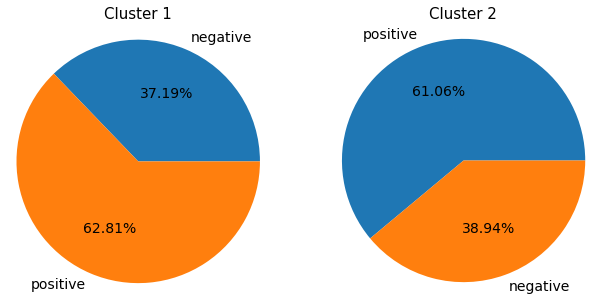

In [35]:
plot_pie(labels_dict)